In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb

from astroquery.esasky import ESASky

from photutils.aperture import CircularAnnulus, CircularAperture
from photutils.aperture import aperture_photometry, ApertureStats

from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

In [2]:
hdul = fits.open("data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f555w_v1_exp-drc-sci.fits")

In [3]:
# hdul[0].header

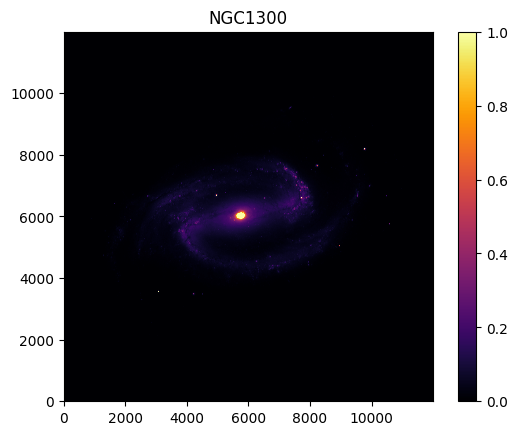

In [4]:
full = hdul[0].data*2
cen = int(full.shape[0]), int(full.shape[1])

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CD1_1'], hdul[0].header['CD2_2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

plt.imshow(full, vmin=0, vmax=1, cmap="inferno", origin='lower')
plt.title("NGC1300")
plt.colorbar()
# plt.savefig("illustrate.png", dpi=300)

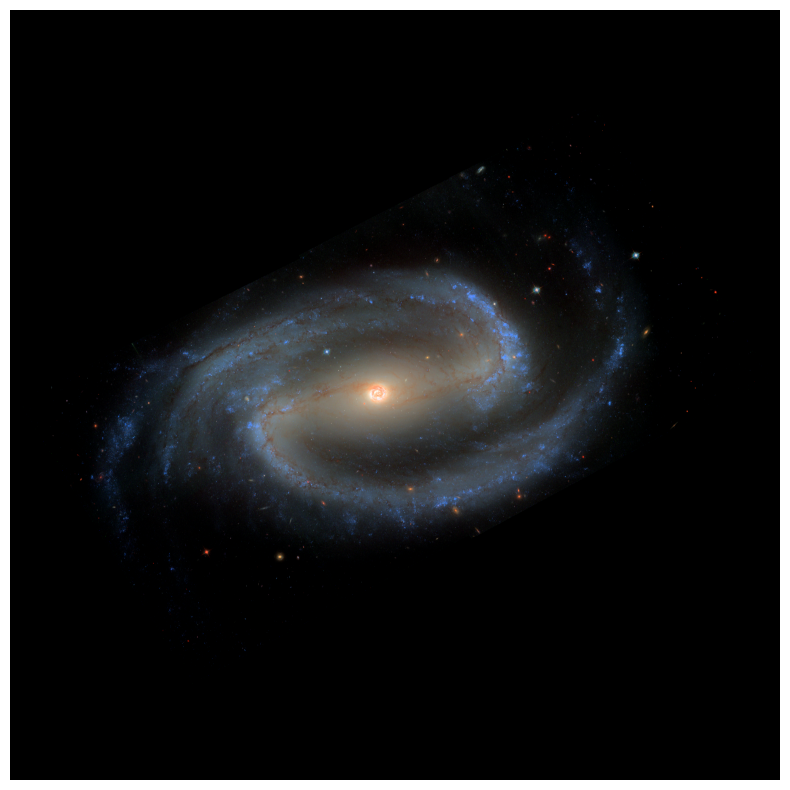

In [5]:
image_list = ["data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f435w_v1_exp-drc-sci.fits",
              "data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f555w_v1_exp-drc-sci.fits",
              "data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f814w_v1_exp-drc-sci.fits"]

images = [fits.getdata(file) for file in image_list]

norm_images = [img / np.percentile(img, 99) for img in images]

filtered_images = [gaussian_filter(img, sigma=1) for img in norm_images]

rgb_image = make_lupton_rgb(filtered_images[2], filtered_images[1], filtered_images[0], stretch=1, Q=5)

p0, p100 = np.percentile(rgb_image, (0, 100))
rgb_image = np.clip((rgb_image - p0) / (p100 - p0), 0, 1)


plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.axis('off')
plt.show()

In [6]:
dat = Table.read("data/ngc1300mosaic/catalogs/hlsp_phangs-cat_hst_acs-uvis_ngc1300_multi_v1_obs-human-compact-association-class3.fits")
class3 = dat.to_pandas()
# class3

In [7]:
filtered_class3 = class3[class3["PHANGS_CLUSTER_CLASS_HUMAN"] == 3.0]
class3_mag_275 = filtered_class3.PHANGS_F275W_VEGA
class3_mag_336 = filtered_class3.PHANGS_F336W_VEGA
class3_mag_435 = filtered_class3.PHANGS_F435W_VEGA
class3_mag_555 = filtered_class3.PHANGS_F555W_VEGA
class3_mag_814 = filtered_class3.PHANGS_F814W_VEGA

class3_ra = filtered_class3.PHANGS_RA
class3_dec = filtered_class3.PHANGS_DEC

In [8]:
dat = Table.read("data/ngc1300mosaic/catalogs/hlsp_phangs-cat_hst_acs-uvis_ngc1300_multi_v1_obs-human-cluster-class12.fits")
class12 = dat.to_pandas()
# class12

In [9]:
filtered_class1 = class12[class12["PHANGS_CLUSTER_CLASS_HUMAN"] == 1.0]
class1_mag_275 = filtered_class1.PHANGS_F275W_VEGA
class1_mag_336 = filtered_class1.PHANGS_F336W_VEGA
class1_mag_435 = filtered_class1.PHANGS_F435W_VEGA
class1_mag_555 = filtered_class1.PHANGS_F555W_VEGA
class1_mag_814 = filtered_class1.PHANGS_F814W_VEGA

class1_ra = filtered_class1.PHANGS_RA
class1_dec = filtered_class1.PHANGS_DEC

filtered_class2 = class12[class12["PHANGS_CLUSTER_CLASS_HUMAN"] == 2.0]
class2_mag_275 = filtered_class2.PHANGS_F275W_VEGA
class2_mag_336 = filtered_class2.PHANGS_F336W_VEGA
class2_mag_435 = filtered_class2.PHANGS_F435W_VEGA
class2_mag_555 = filtered_class2.PHANGS_F555W_VEGA
class2_mag_814 = filtered_class2.PHANGS_F814W_VEGA

class2_ra = filtered_class2.PHANGS_RA
class2_dec = filtered_class2.PHANGS_DEC

In [10]:
# class12.loc[0]

<Figure size 1000x1000 with 0 Axes>

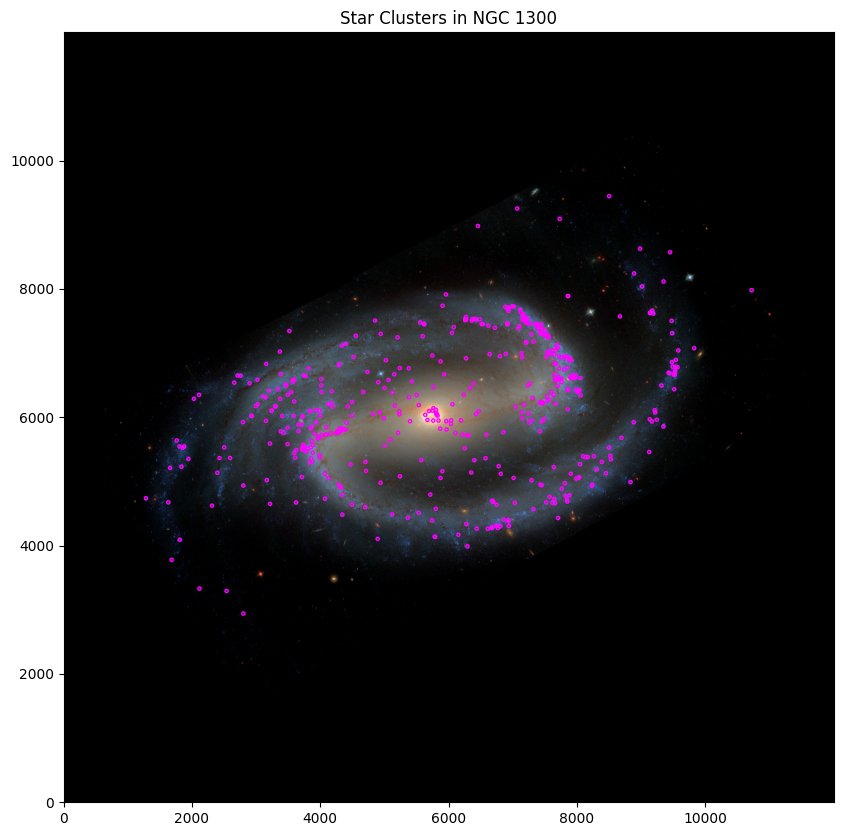

In [11]:
targra, targdec = np.concatenate((class1_ra, class2_ra, class3_ra)), np.concatenate((class1_dec, class2_dec, class3_dec))

p1, p2 = cpix1+(targra-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(targdec-cendec)/deldec

plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(rgb_image, origin='lower')
Circles = [plt.Circle((p1[i], p2[i]), radius=25, edgecolor='magenta', facecolor='None') for i in range(len(p1))]
for c in Circles:
    ax.add_artist(c)
plt.title("Star Clusters in NGC 1300")
# plt.savefig("star clusters.png", dpi=300)
plt.show()

In [12]:
positions = []
for xi, yi in zip(p1, p2):
    positions.append((xi, yi))

In [13]:
header = hdul[0].header
data = hdul[0].data

w = WCS(header)

[raImage, decImage] = w.all_pix2world(data.shape[0]/2, data.shape[1]/2, 1)

In [14]:
result = ESASky.query_region_catalogs(position=SkyCoord(ra=raImage, dec=decImage, unit=(u.deg, u.deg)), radius=3*u.arcmin, catalogs="HSC", row_limit=40000)
# result[0]

In [15]:
lim = 20
k = result[0].to_pandas()
k.sort_values('flux', inplace=True)
k.reset_index(drop=True, inplace=True)
ara, adec = k[k.flux<lim].ra, k[k.flux<lim].dec
k[(k["filter"] == "a_f435w")]

,abs_corr,ci,ci_sigma,dsigma,extinction,htmid,kron_radius,kron_radius_sigma,num_filters,num_visits,...,z,match_id,target_name,num_images,num_images_per_filter,ra,dec,filter,flux,flux_sigma
19,Y,1.385432,0.599130,11.438975,0.030270,9734578459671,0.1750,0.000000,3,2,...,-0.332792,97372814,NGC1300-POS2,3,1,49.952180,-19.438356,a_f435w,19.122900,0.0
31,Y,4.204036,5.344794,22.280475,0.030270,9734592434459,0.2100,0.078262,5,3,...,-0.332092,105351941,NGC1300-POS1,5,1,49.899809,-19.395799,a_f435w,19.821301,0.0
39,Y,1.798935,0.205650,0.000000,0.029547,9734591975246,0.3265,0.000000,2,1,...,-0.331955,78123665,NGC1300-POS1,2,1,49.874122,-19.387495,a_f435w,20.004499,0.0
42,Y,6.049815,3.526216,35.939362,0.029547,9734591975244,0.1750,0.000000,4,2,...,-0.331954,41067569,NGC1300-POS1,4,1,49.874098,-19.387444,a_f435w,20.094000,0.0
70,Y,1.085588,0.315073,28.282992,0.030270,9734592334473,0.2310,0.125220,5,3,...,-0.332373,46563140,NGC1300-POS2,5,1,49.923479,-19.412878,a_f435w,20.561001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23944,Y,1.040833,0.000000,0.000000,0.029547,9734592133809,0.3155,0.000000,1,1,...,-0.331770,27070426,NGC1300-POS1,1,1,49.885216,-19.376226,a_f435w,26.630899,0.0
23945,Y,1.665231,0.155760,0.000000,0.029547,9734592049957,0.4025,0.000000,2,1,...,-0.331729,56940264,NGC1300-POS1,2,1,49.904143,-19.373735,a_f435w,26.632099,0.0
23947,Y,1.020833,0.173110,0.000000,0.030270,9734578910634,0.2605,0.000000,2,1,...,-0.332305,107217856,NGC1300-POS2,2,1,49.964680,-19.408742,a_f435w,26.635599,0.0
23949,Y,0.965463,0.000000,0.000000,0.029547,9734592096434,0.2070,0.000000,1,1,...,-0.331679,60524317,NGC1300-POS1,1,1,49.887911,-19.370736,a_f435w,26.645201,0.0


<Figure size 1000x1000 with 0 Axes>

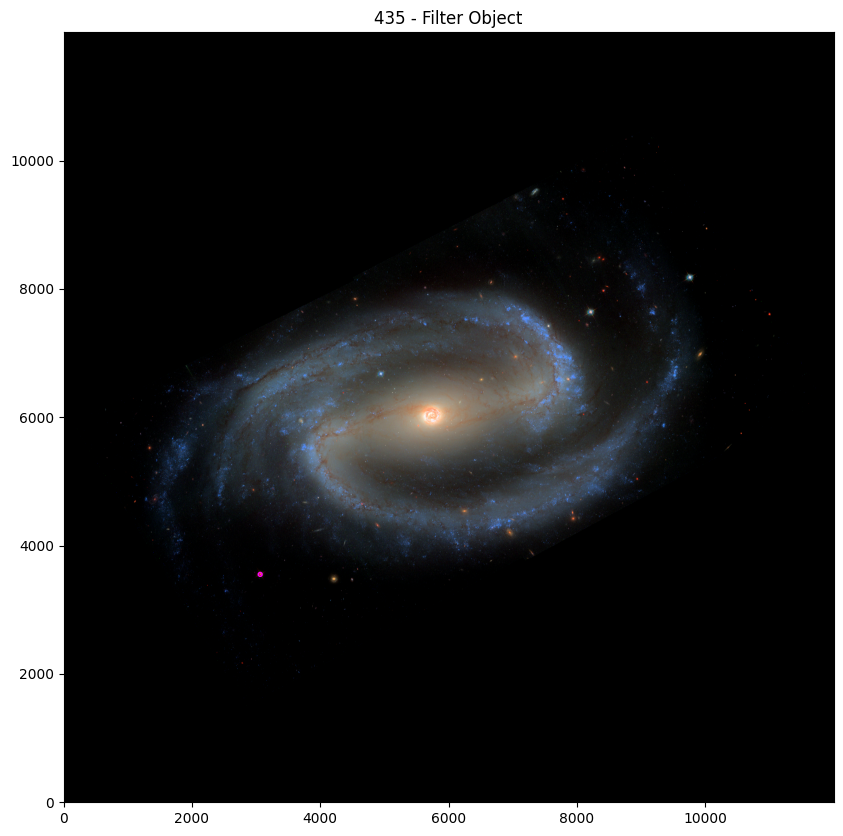

In [16]:
hdul = fits.open("data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f435w_v1_exp-drc-sci.fits")
data = hdul[0].data

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CD1_1'], hdul[0].header['CD2_2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

targra, targdec, refmag = k.ra[19], k.dec[19], k.flux[19]

p1, p2 = cpix1+(targra-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(targdec-cendec)/deldec

plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(rgb_image, origin='lower')
Circles = [plt.Circle((p1, p2), radius=30, edgecolor='magenta', facecolor='None')]
for c in Circles:
    ax.add_artist(c)
plt.title("435 - Filter Object")
# plt.savefig("435 object.png", dpi=300)
plt.show()

In [17]:
position = (p1, p2)
apertures = CircularAperture(position, r=4)
annulus_apertures = CircularAnnulus(position, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(full)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub

for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

zero_point = refmag + 2.5*np.log10(phot_table["aperture_sum_bkgsub"][0])
zero_point

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
       pix       pix                                              
--- --------- --------- ------------ --------- -------------------
  1 3063.0461 3550.9226    425.98567 6.0087175           419.97695


25.680963652048174

 id  xcenter   ycenter  aperture_sum total_bkg  aperture_sum_bkgsub
       pix       pix                                               
--- --------- --------- ------------ ---------- -------------------
  1 6293.4299  3987.683    4.7351735 0.92137331           3.8138002
  2 4894.9281 4104.4015     2.787111 0.33216011           2.4549509
  3 5782.1925 4137.3217    4.3037909  1.5610641           2.7427268
  4 6151.5087 4168.4508    3.3764216 0.80721143           2.5692101
  5 6611.4419 4261.2427    3.0255275  1.4518482           1.5736793
  6 5741.8919 4392.9923    6.0838651  1.1037813           4.9800838
  7 7705.7212 4430.0685    3.6910596 0.55862809           3.1324316
  8 5365.8027 4433.3537    3.0698673 0.82669636           2.2431709
  9 2312.6466 4622.5506    2.0535507 0.26913133           1.7844194
 10  6747.709 4635.4389    3.1250261   1.159089           1.9659371
 11 4495.6911 4636.2467    2.1748947 0.85870338           1.3161913
 12 3217.5759 4650.4023    4.3246067 0.38392409 

Text(0.5, 1.0, '435 Filter Plot')

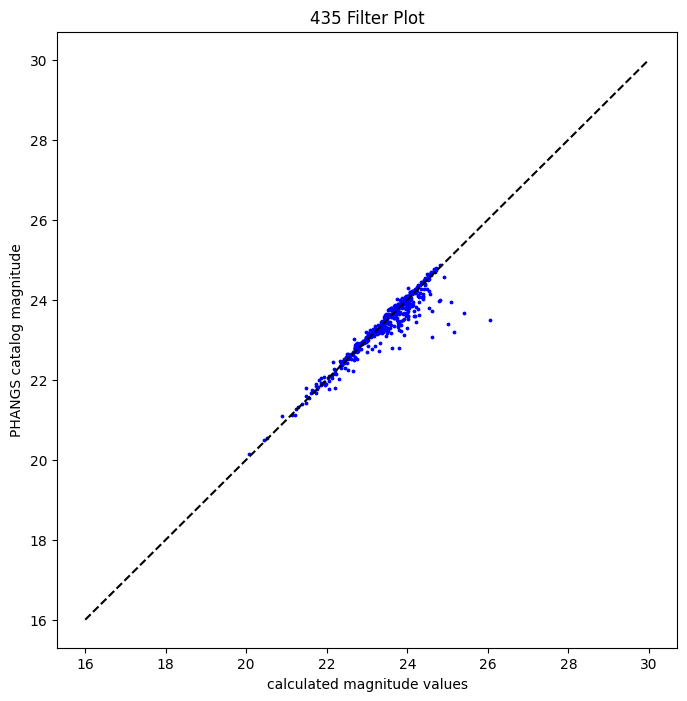

In [18]:
apertures = CircularAperture(positions, r=4)
annulus_apertures = CircularAnnulus(positions, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

magnitude_435 = zero_point - 2.5*np.log10(np.abs(phot_table["aperture_sum_bkgsub"]))-0.8

plt.figure(figsize=(8, 8))
plt.scatter(magnitude_435, np.concatenate((class1_mag_435, class2_mag_435, class3_mag_435)), s=3, color="blue")
plt.plot([16, 30], [16, 30], linestyle="dashed", color="k")
plt.xlabel("calculated magnitude values")
plt.ylabel("PHANGS catalog magnitude")
plt.title("435 Filter Plot")
# plt.savefig("435 plot.png", dpi=300)

In [19]:
lim = 20
k = result[0].to_pandas()
k.sort_values('flux', inplace=True)
k.reset_index(drop=True, inplace=True)
ara, adec = k[k.flux<lim].ra, k[k.flux<lim].dec
k[(k["filter"] == "a_f555w")]

,abs_corr,ci,ci_sigma,dsigma,extinction,htmid,kron_radius,kron_radius_sigma,num_filters,num_visits,...,z,match_id,target_name,num_images,num_images_per_filter,ra,dec,filter,flux,flux_sigma
20,Y,1.085588,0.315073,28.282992,0.030270,9734592334473,0.2310,0.125220,5,3,...,-0.332373,46563140,NGC1300-POS2,5,1,49.923479,-19.412878,a_f555w,19.155100,0.0
23,Y,4.204036,5.344794,22.280475,0.030270,9734592434459,0.2100,0.078262,5,3,...,-0.332092,105351941,NGC1300-POS1,5,1,49.899809,-19.395799,a_f555w,19.245300,0.0
24,Y,1.385432,0.599130,11.438975,0.030270,9734578459671,0.1750,0.000000,3,2,...,-0.332792,97372814,NGC1300-POS2,3,1,49.952180,-19.438356,a_f555w,19.346100,0.0
29,Y,1.437269,0.014616,10.685867,0.030270,9734591989921,0.1750,0.000000,4,2,...,-0.331992,23664151,NGC1300-POS1,4,1,49.889836,-19.389750,a_f555w,19.781300,0.0
30,Y,6.049815,3.526216,35.939362,0.029547,9734591975244,0.1750,0.000000,4,2,...,-0.331954,41067569,NGC1300-POS1,4,1,49.874098,-19.387444,a_f555w,19.819599,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23908,Y,1.049722,0.000000,0.000000,0.029547,9734592084317,0.3000,0.000000,1,1,...,-0.331809,23682450,NGC1300-POS1,1,1,49.897115,-19.378601,a_f555w,26.588699,0.0
23921,Y,1.159444,0.000000,0.000000,0.030270,9734592467785,0.3115,0.000000,1,1,...,-0.332101,2848076,NGC1300-POS2,1,1,49.948970,-19.396360,a_f555w,26.594500,0.0
23926,Y,1.102917,0.076800,0.000000,0.029547,9734592132811,0.3570,0.000000,2,1,...,-0.331734,41197905,NGC1300-POS1,2,1,49.887894,-19.374069,a_f555w,26.598499,0.0
23931,Y,1.048889,0.062985,0.000000,0.029547,9734592073893,0.2805,0.000000,2,1,...,-0.331715,107533387,NGC1300-POS1,2,1,49.896029,-19.372883,a_f555w,26.604700,0.0


<Figure size 1000x1000 with 0 Axes>

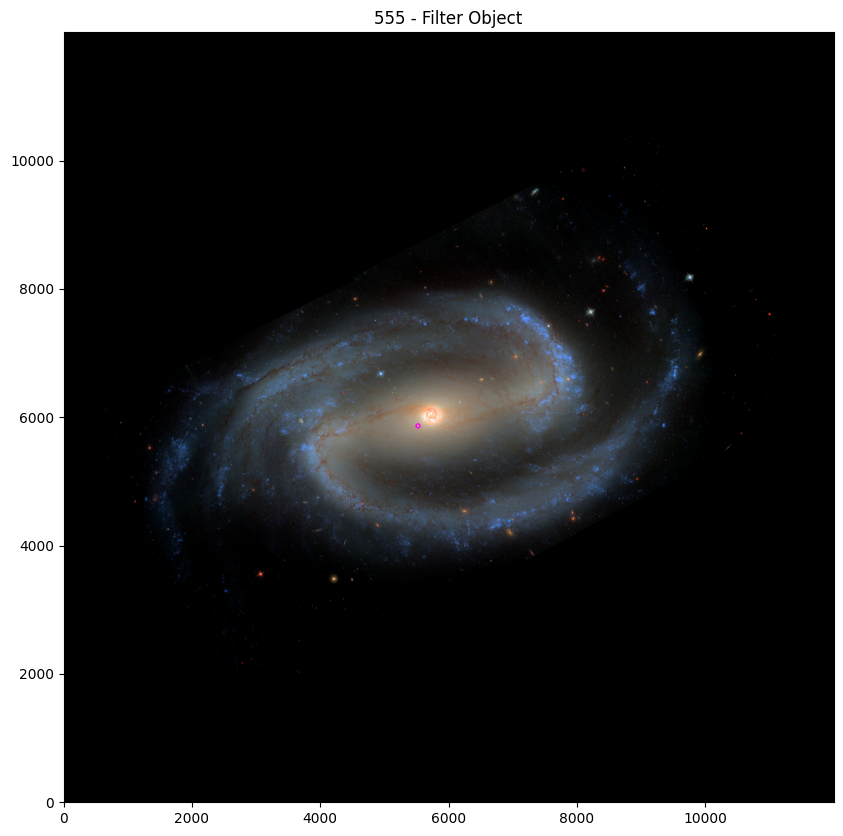

In [20]:
hdul = fits.open("data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f555w_v1_exp-drc-sci.fits")
data = hdul[0].data

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CD1_1'], hdul[0].header['CD2_2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

targra, targdec, refmag = k.ra[20], k.dec[20], k.flux[20]

p1, p2 = cpix1+(targra-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(targdec-cendec)/deldec

plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(rgb_image, origin='lower')
Circles = [plt.Circle((p1, p2), radius=30, edgecolor='magenta', facecolor='None')]
for c in Circles:
    ax.add_artist(c)
plt.title("555 - Filter Object")
# plt.savefig("555 object.png", dpi=300)
plt.show()

In [21]:
position = (p1, p2)
apertures = CircularAperture(position, r=4)
annulus_apertures = CircularAnnulus(position, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(full)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

zero_point = refmag + 2.5*np.log10(phot_table["aperture_sum_bkgsub"][0])
zero_point

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
       pix       pix                                              
--- --------- --------- ------------ --------- -------------------
  1 5522.6382 5865.9337    412.69229 14.330495           398.36179


25.65579405921348

 id  xcenter   ycenter  aperture_sum total_bkg  aperture_sum_bkgsub
       pix       pix                                               
--- --------- --------- ------------ ---------- -------------------
  1 6293.4299  3987.683    4.8267319  1.1155614           3.7111705
  2 4894.9281 4104.4015    3.2141146 0.49620416           2.7179105
  3 5782.1925 4137.3217    4.4375886  1.8565878           2.5810008
  4 6151.5087 4168.4508    4.4214095  1.1598874           3.2615221
  5 6611.4419 4261.2427    4.0425486  1.8792376           2.1633109
  6 5741.8919 4392.9923    7.7180315  1.6412296           6.0768019
  7 7705.7212 4430.0685    4.5956369 0.86466317           3.7309737
  8 5365.8027 4433.3537    4.6376568  1.4271725           3.2104843
  9 2312.6466 4622.5506    2.7607647 0.48060348           2.2801612
 10  6747.709 4635.4389    4.3875583  1.9009037           2.4866546
 11 4495.6911 4636.2467    4.3329483  1.6285177           2.7044305
 12 3217.5759 4650.4023    4.8551026 0.53698208 

Text(0.5, 1.0, '555 Filter Plot')

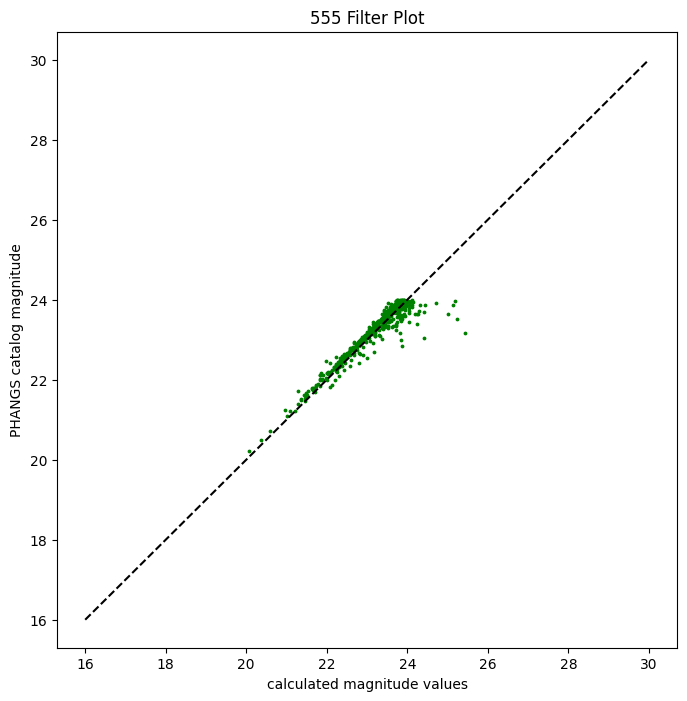

In [22]:
apertures = CircularAperture(positions, r=4)
annulus_apertures = CircularAnnulus(positions, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

magnitude_555 = zero_point - 2.5*np.log10(np.abs(phot_table["aperture_sum_bkgsub"]))-0.85

plt.figure(figsize=(8, 8))
plt.scatter(magnitude_555, np.concatenate((class1_mag_555, class2_mag_555, class3_mag_555)), s=3, color="green")
plt.plot([16, 30], [16, 30], linestyle="dashed", color="k")
plt.xlabel("calculated magnitude values")
plt.ylabel("PHANGS catalog magnitude")
plt.title("555 Filter Plot")
# plt.savefig("555 plot.png", dpi=300)

In [23]:
lim = 20
k = result[0].to_pandas()
k.sort_values('flux', inplace=True)
k.reset_index(drop=True, inplace=True)
ara, adec = k[k.flux<lim].ra, k[k.flux<lim].dec
k[(k["filter"] == "a_f814w")]

,abs_corr,ci,ci_sigma,dsigma,extinction,htmid,kron_radius,kron_radius_sigma,num_filters,num_visits,...,z,match_id,target_name,num_images,num_images_per_filter,ra,dec,filter,flux,flux_sigma
5,Y,2.427615,1.030442,200.512619,0.030270,9734592335568,0.268333,0.161658,3,2,...,-0.332345,97450691,NGC1300-POS2,3,1,49.921089,-19.411174,a_f814w,17.517200,0.0
8,Y,1.437269,0.014616,10.685867,0.030270,9734591989921,0.175000,0.000000,4,2,...,-0.331992,23664151,NGC1300-POS1,4,1,49.889836,-19.389750,a_f814w,17.931200,0.0
11,Y,1.067315,0.094426,3.348006,0.030270,9734592784703,0.175000,0.000000,4,2,...,-0.332524,44260,NGC1300-POS1,4,1,49.883690,-19.422031,a_f814w,18.625000,0.0
13,Y,1.085588,0.315073,28.282992,0.030270,9734592334473,0.231000,0.125220,5,3,...,-0.332373,46563140,NGC1300-POS2,5,1,49.923479,-19.412878,a_f814w,18.681499,0.0
14,Y,1.028796,0.115395,2.987911,0.029547,9734592074262,0.175000,0.000000,4,2,...,-0.331733,44673174,NGC1300-POS1,4,1,49.897185,-19.373997,a_f814w,18.755699,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23946,Y,1.128982,0.083723,17.218680,0.030270,9734592620176,0.323167,0.002887,3,2,...,-0.331898,7318807,NGC1300-POS1,3,1,49.916863,-19.384002,a_f814w,26.632601,0.0
23948,Y,1.629630,0.000000,0.000000,0.030270,9734593057100,0.345500,0.000000,2,1,...,-0.332161,64590566,NGC1300-POS1,2,1,49.878201,-19.399986,a_f814w,26.638000,0.0
23950,Y,1.840370,0.150457,0.000000,0.030270,9734592513472,0.185000,0.000000,2,1,...,-0.332143,46793271,NGC1300-POS2,2,1,49.935752,-19.398896,a_f814w,26.654800,0.0
23951,Y,1.460833,0.000000,0.000000,0.030270,9734578436115,0.338000,0.000000,1,1,...,-0.332568,56074704,NGC1300-POS2,1,1,49.960992,-19.424698,a_f814w,26.680401,0.0


<Figure size 1000x1000 with 0 Axes>

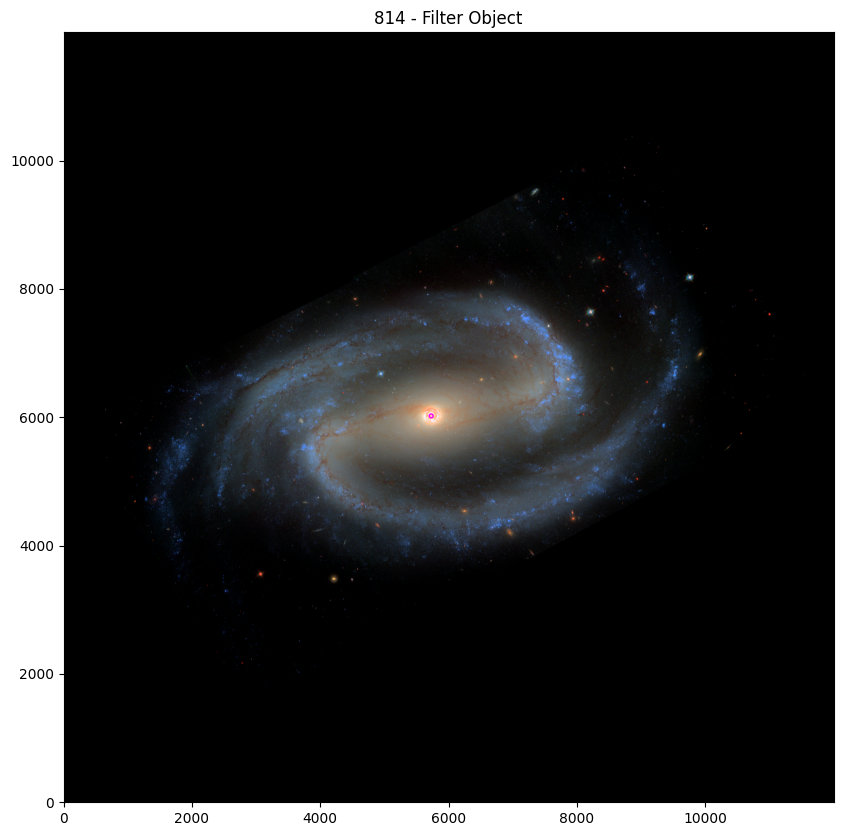

In [24]:
hdul = fits.open("data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_acs-wfc_ngc1300mosaic_f814w_v1_exp-drc-sci.fits")
data = hdul[0].data

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CD1_1'], hdul[0].header['CD2_2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

targra, targdec, refmag = k.ra[5], k.dec[5], k.flux[5]

p1, p2 = cpix1+(targra-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(targdec-cendec)/deldec

plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
plt.imshow(rgb_image, origin='lower')
Circles = [plt.Circle((p1, p2), radius=30, edgecolor='magenta', facecolor='None')]
for c in Circles:
    ax.add_artist(c)
plt.title("814 - Filter Object")
# plt.savefig("814 object.png", dpi=300)
plt.show()

In [25]:
position = (p1, p2)
apertures = CircularAperture(position, r=4)
annulus_apertures = CircularAnnulus(position, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(full)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

zero_point = refmag + 2.5*np.log10(phot_table["aperture_sum_bkgsub"][0])
zero_point

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
       pix       pix                                              
--- --------- --------- ------------ --------- -------------------
  1 5727.4491 6020.7668    1814.6516 1186.2445           628.40705


24.512803088022025

 id  xcenter   ycenter  aperture_sum total_bkg  aperture_sum_bkgsub
       pix       pix                                               
--- --------- --------- ------------ ---------- -------------------
  1 6293.4299  3987.683    6.2593533  1.6878955           4.5714578
  2 4894.9281 4104.4015    4.3744032   1.086756           3.2876472
  3 5782.1925 4137.3217    4.7290819  2.8774994           1.8515826
  4 6151.5087 4168.4508    6.7763093  2.4293334           4.3469759
  5 6611.4419 4261.2427    5.4000621  3.2457464           2.1543156
  6 5741.8919 4392.9923    11.837626  3.4290637           8.4085624
  7 7705.7212 4430.0685    6.6180968  1.6841607           4.9339361
  8 5365.8027 4433.3537    10.256957  3.2622724           6.9946848
  9 2312.6466 4622.5506    5.1380911 0.80409736           4.3339938
 10  6747.709 4635.4389    7.3196553  4.1524754           3.1671798
 11 4495.6911 4636.2467    11.786347  4.3730126           7.4133344
 12 3217.5759 4650.4023    6.0395288  1.0027684 

Text(0.5, 1.0, '814 Filter Plot')

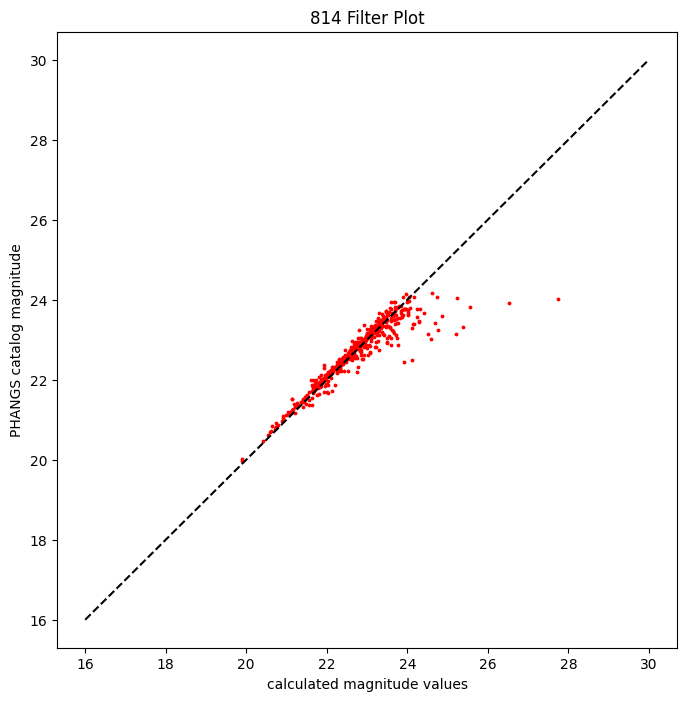

In [26]:
apertures = CircularAperture(positions, r=4)
annulus_apertures = CircularAnnulus(positions, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
phot_table["aperture_sum_bkgsub"] = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

magnitude_814 = zero_point - 2.5*np.log10(np.abs(phot_table["aperture_sum_bkgsub"]))+0.05

plt.figure(figsize=(8, 8))
plt.scatter(magnitude_814, np.concatenate((class1_mag_814, class2_mag_814, class3_mag_814)), s=3, color="red")
plt.plot([16, 30], [16, 30], linestyle="dashed", color="k")
plt.xlabel("calculated magnitude values")
plt.ylabel("PHANGS catalog magnitude")
plt.title("814 Filter Plot")
# plt.savefig("814 plot.png", dpi=300)

 id  xcenter   ycenter  aperture_sum   total_bkg  
       pix       pix                              
--- --------- --------- ------------ -------------
  1 6293.4299  3987.683   0.91730572   0.092196941
  2 4894.9281 4104.4015   0.19993456  -0.052336492
  3 5782.1925 4137.3217    1.0667385    0.22389413
  4 6151.5087 4168.4508   0.11272001 -0.0076300927
  5 6611.4419 4261.2427   0.60076718    0.14802742
  6 5741.8919 4392.9923   0.24774526 0.00095649282
  7 7705.7212 4430.0685  0.089653058   0.053119593
  8 5365.8027 4433.3537   0.14921061   0.028459159
  9 2312.6466 4622.5506  0.075648888   0.011776312
 10  6747.709 4635.4389   0.14452701   0.053675039
 11 4495.6911 4636.2467  0.073226494   0.010564893
 12 3217.5759 4650.4023   0.24786113  0.0084128503
...       ...       ...          ...           ...
485 7211.6128 7551.6196    1.6116631     2.2063198
486 6268.9816 7562.7724    1.0989415    0.18498587
487 7152.2458 7592.9048    2.7860879    0.82796446
488 9139.0952 7622.0531   0.871

Text(0.5, 1.0, '275 Filter Plot')

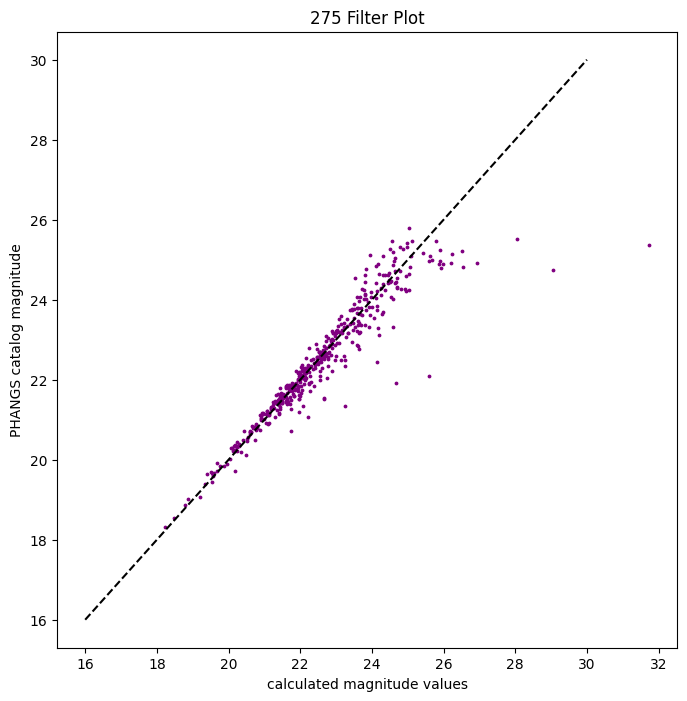

In [27]:
hdul = fits.open("data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_wfc3-uvis_ngc1300mosaic_f275w_v1_exp-drc-sci.fits")
data = hdul[0].data

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CD1_1'], hdul[0].header['CD2_2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

apertures = CircularAperture(positions, r=4)
annulus_apertures = CircularAnnulus(positions, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
aperture_sum_bkgsub = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

valid_mask = aperture_sum_bkgsub > 0
filtered_aperture_sum_bkgsub = aperture_sum_bkgsub[valid_mask]

# Calculate magnitude for valid data
magnitude_275 = 21.5 - 2.5 * np.log10(filtered_aperture_sum_bkgsub)

# Corresponding valid class magnitudes
valid_class_mag_275 = np.concatenate((class1_mag_275, class2_mag_275, class3_mag_275))[valid_mask]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(magnitude_275, valid_class_mag_275, s=3, color="purple")
plt.plot([16, 30], [16, 30], linestyle="dashed", color="k")
plt.xlabel("calculated magnitude values")
plt.ylabel("PHANGS catalog magnitude")
plt.title("275 Filter Plot")
# plt.savefig("275 plot.png", dpi=300)

 id  xcenter   ycenter  aperture_sum   total_bkg  
       pix       pix                              
--- --------- --------- ------------ -------------
  1 6293.4299  3987.683    1.5225881    0.16098829
  2 4894.9281 4104.4015    0.3966179  -0.015350335
  3 5782.1925 4137.3217    1.7765881    0.58368479
  4 6151.5087 4168.4508    0.3275719  0.0087108547
  5 6611.4419 4261.2427    1.1512159    0.28503939
  6 5741.8919 4392.9923   0.75406866    0.09555668
  7 7705.7212 4430.0685   0.40784517   0.048878093
  8 5365.8027 4433.3537   0.35835846   0.078451782
  9 2312.6466 4622.5506    0.1968674 -0.0084444687
 10  6747.709 4635.4389   0.32225628   0.092988843
 11 4495.6911 4636.2467   0.16966119   0.023599998
 12 3217.5759 4650.4023   0.60056397    0.02704878
...       ...       ...          ...           ...
485 7211.6128 7551.6196     3.471169      3.499034
486 6268.9816 7562.7724    2.0021147    0.39616115
487 7152.2458 7592.9048    5.3659369     1.8012127
488 9139.0952 7622.0531    1.57

Text(0.5, 1.0, '336 Filter Plot')

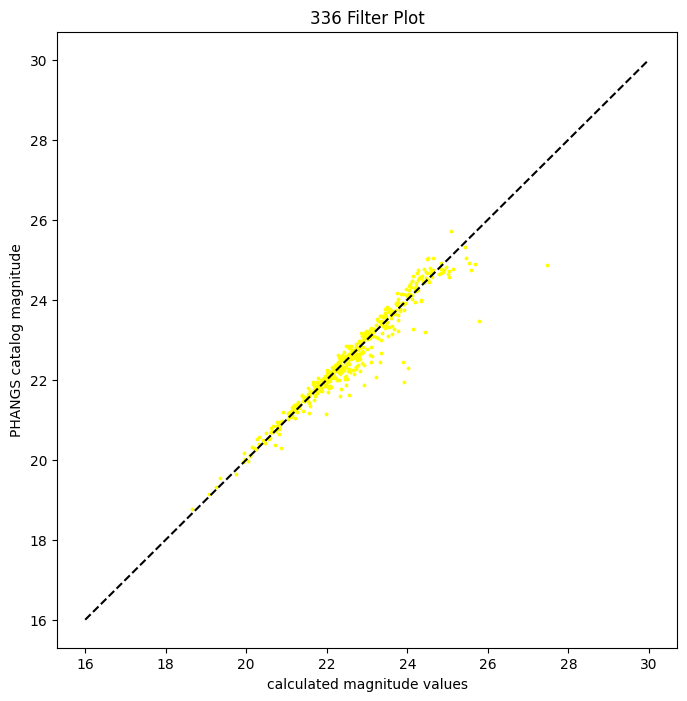

In [28]:
hdul = fits.open("data/ngc1300mosaic/sci/hlsp_phangs-hst_hst_wfc3-uvis_ngc1300mosaic_f336w_v1_exp-drc-sci.fits")
data = hdul[0].data

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CD1_1'], hdul[0].header['CD2_2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

apertures = CircularAperture(positions, r=4)
annulus_apertures = CircularAnnulus(positions, r_in=7, r_out=8)

phot_table = aperture_photometry(data, apertures)
phot_table["aperture_sum"].info.format = "%.8g"

aperstats = ApertureStats(data, annulus_apertures)
bkg_mean = aperstats.mean

aperture_area = apertures.area_overlap(data)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table["aperture_sum"] - total_bkg

phot_table["total_bkg"] = total_bkg
aperture_sum_bkgsub = phot_bkgsub
for col in phot_table.colnames:
    phot_table[col].info.format = "%.8g"
print(phot_table)

valid_mask = aperture_sum_bkgsub > 0
filtered_aperture_sum_bkgsub = aperture_sum_bkgsub[valid_mask]

# Calculate magnitude for valid data
magnitude_336 = 22.5 - 2.5 * np.log10(filtered_aperture_sum_bkgsub)

# Corresponding valid class magnitudes
valid_class_mag_336 = np.concatenate((class1_mag_336, class2_mag_336, class3_mag_336))[valid_mask]

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(magnitude_336, valid_class_mag_336, s=3, color="yellow")
plt.plot([16, 30], [16, 30], linestyle="dashed", color="k")
plt.xlabel("calculated magnitude values")
plt.ylabel("PHANGS catalog magnitude")
plt.title("336 Filter Plot")
# plt.savefig("336 plot.png", dpi=300)

In [29]:
model_ub_sol = np.load("data/model_ub_sol.npy")
model_vi_sol = np.load("data/model_vi_sol.npy")
age_mod_sol = np.load("data/age_mod_sol.npy")

# model_ub_sol50 = np.load("data/model_ub_sol50.npy")
# model_vi_sol50 = np.load("data/model_ub_sol50.npy")
# age_mod_sol50 = np.load("data/age_mod_sol50.npy")

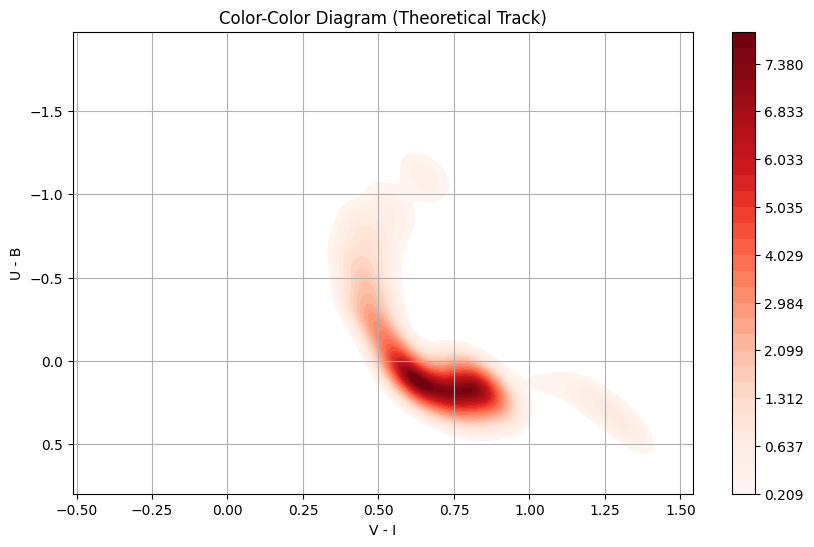

In [30]:
color_1 = model_ub_sol
color_2 = model_vi_sol
ages = age_mod_sol

plt.figure(figsize=(10, 6))
sns.kdeplot(x=color_2, y=color_1, fill=True, cmap="Reds", cbar=True, levels=30)
plt.gca().invert_yaxis()

plt.xlabel('V - I')
plt.ylabel('U - B')
plt.title('Color-Color Diagram (Theoretical Track)')

plt.grid(True)
plt.show()

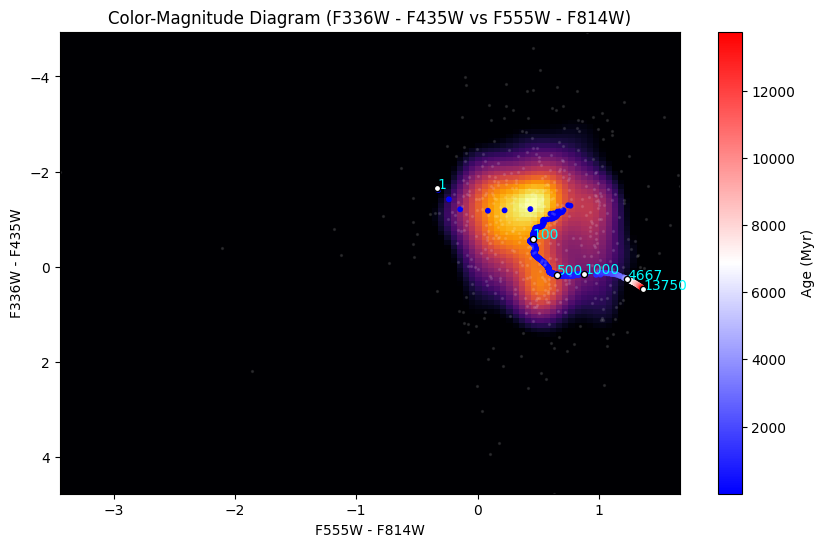

In [31]:
min_index = min(len(magnitude_336), len(magnitude_435))
color_336_435 = magnitude_336[:min_index] - magnitude_435[:min_index]
color_555_814 = magnitude_555[:min_index] - magnitude_814[:min_index]

plt.figure(figsize=(10, 6))

xy = np.vstack([color_555_814, color_336_435])
z = gaussian_kde(xy)(xy)

bandwidth = 0.3
xmin, xmax = color_555_814.min(), color_555_814.max()
ymin, ymax = color_336_435.min(), color_336_435.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = gaussian_kde(xy, bw_method=bandwidth)
zz = np.reshape(f(positions).T, xx.shape)

zz_norm = zz / zz.max()

plt.imshow(np.rot90(zz_norm), cmap='inferno', extent=[xmin, xmax, ymin, ymax], aspect='auto', vmin=0.2)

sc = plt.scatter(model_vi_sol, model_ub_sol, c=age_mod_sol, cmap='bwr', s=10)
cbar = plt.colorbar(sc, label='Age (Myr)')

indices = [0, 99, 499, 999, 1024, 1048]
for i in indices:
    plt.scatter(model_vi_sol[i], model_ub_sol[i], color='white', s=20, edgecolor='black', zorder=5)
    plt.text(model_vi_sol[i], model_ub_sol[i], f'{int(age_mod_sol[i])}', fontsize=10, color='cyan')

plt.gca().invert_yaxis()

plt.scatter(color_555_814, color_336_435, c='white', s=2, alpha=0.1)

plt.xlabel('F555W - F814W')
plt.ylabel('F336W - F435W')
plt.title('Color-Magnitude Diagram (F336W - F435W vs F555W - F814W)')
# plt.savefig("cc mag.png", dpi=300)
plt.show()

In [32]:
young_ra = list()
young_dec = list()

middle_ra = list()
middle_dec = list()

old_ra = list()
old_dec = list()

In [ ]:
color_336_435 = class1_mag_336 - class1_mag_435
color_555_814 = class1_mag_555 - class1_mag_814

valid_mask = (color_336_435 >= -2) & (color_336_435 <= 2) & (color_555_814 >= -2) & (color_555_814 <= 2)
color_336_435 = color_336_435[valid_mask]
color_555_814 = color_555_814[valid_mask]
class1_ra = class1_ra[valid_mask]
class1_dec = class1_dec[valid_mask]

young_cluster_mask = (color_555_814 < 0.6) & (color_336_435 < -1.2)
middle_aged_cluster_mask = (color_555_814 > 0.2) & (color_555_814 < 0.8) & (color_336_435 > -1.1) & (color_336_435 < 0.3)
old_cluster_mask = (color_555_814 > 1) & (color_336_435 > 0)

young_x = color_555_814[young_cluster_mask]
young_y = color_336_435[young_cluster_mask]
young_ra = young_ra + list(class1_ra[young_cluster_mask])
young_dec = young_dec + list(class1_dec[young_cluster_mask])

middle_x = color_555_814[middle_aged_cluster_mask]
middle_y = color_336_435[middle_aged_cluster_mask]
middle_ra = middle_ra + list(class1_ra[middle_aged_cluster_mask])
middle_dec = middle_dec + list(class1_dec[middle_aged_cluster_mask])

old_x = color_555_814[old_cluster_mask]
old_y = color_336_435[old_cluster_mask]
old_ra = old_ra + list(class1_ra[old_cluster_mask])
old_dec = old_dec + list(class1_dec[old_cluster_mask])

def calculate_kde(x, y):
    if len(x) > 1 and len(y) > 1:
        kde = gaussian_kde(np.vstack([x, y]))
        return kde
    else:
        return None

kde_young = calculate_kde(young_x, young_y)
kde_middle = calculate_kde(middle_x, middle_y)
kde_old = calculate_kde(old_x, old_y)

x_grid = np.linspace(-1, 2, 100)
y_grid = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

Z_young = kde_young(positions).T if kde_young else None
Z_middle = kde_middle(positions).T if kde_middle else None
Z_old = kde_old(positions).T if kde_old else None

def find_contour_threshold(Z):
    if Z is not None:
        return np.max(Z) * 0.1
    return None

threshold_young = find_contour_threshold(Z_young)
threshold_middle = find_contour_threshold(Z_middle)
threshold_old = find_contour_threshold(Z_old)

plt.figure(figsize=(10, 6))
plt.gca().invert_yaxis()
plt.scatter(color_555_814, color_336_435, c='green', label='Data', alpha=0.5, s=10)
sc = plt.scatter(model_vi_sol, model_ub_sol, c=age_mod_sol, cmap='magma', s=10)
cbar = plt.colorbar(sc)
cbar.set_label("Age (Myr)")

if Z_young is not None and threshold_young is not None:
    Z_young = np.reshape(Z_young, X.shape)
    plt.contour(X, Y, Z_young, colors='blue', levels=[threshold_young], alpha=0.8, linewidths=2)
    plt.plot([], [], color='blue', label='Young Cluster')

if Z_middle is not None and threshold_middle is not None:
    Z_middle = np.reshape(Z_middle, X.shape)
    plt.contour(X, Y, Z_middle, colors='orange', levels=[threshold_middle], alpha=0.8, linewidths=2)
    plt.plot([], [], color='orange', label='Middle-Aged Cluster')

if Z_old is not None and threshold_old is not None:
    Z_old = np.reshape(Z_old, X.shape)
    plt.contour(X, Y, Z_old, colors='red', levels=[threshold_old], alpha=0.8, linewidths=2)
    plt.plot([], [], color='red', label='Old Cluster')

plt.xlabel('F555W - F814W')
plt.ylabel('F336W - F435W')
plt.title('Color-Magnitude Diagram (Symmetric Clusters)')
plt.legend()
# plt.savefig("symm.png", dpi=300)
plt.show()

In [ ]:
color_336_435 = class2_mag_336 - class2_mag_435
color_555_814 = class2_mag_555 - class2_mag_814

valid_mask = (color_336_435 >= -2) & (color_336_435 <= 2) & (color_555_814 >= -2) & (color_555_814 <= 2)
color_336_435 = color_336_435[valid_mask]
color_555_814 = color_555_814[valid_mask]
class2_ra = class2_ra[valid_mask]
class2_dec = class2_dec[valid_mask]

young_cluster_mask = (color_555_814 < 0.8) & (color_336_435 < -1.2)
middle_aged_cluster_mask = (color_555_814 > 0.4) & (color_555_814 < 0.8) & (color_336_435 > -0.8) & (color_336_435 < 0.3)
old_cluster_mask = (color_555_814 > 1.1) & (color_336_435 > 0)

young_x = color_555_814[young_cluster_mask]
young_y = color_336_435[young_cluster_mask]
young_ra = young_ra + list(class2_ra[young_cluster_mask])
young_dec = young_dec + list(class2_dec[young_cluster_mask])

middle_x = color_555_814[middle_aged_cluster_mask]
middle_y = color_336_435[middle_aged_cluster_mask]
middle_ra = middle_ra + list(class2_ra[middle_aged_cluster_mask])
middle_dec = middle_dec + list(class2_dec[middle_aged_cluster_mask])

old_x = color_555_814[old_cluster_mask]
old_y = color_336_435[old_cluster_mask]
old_ra = old_ra + list(class2_ra[old_cluster_mask])
old_dec = old_dec + list(class2_dec[old_cluster_mask])

def calculate_kde(x, y):
    if len(x) > 1 and len(y) > 1:
        kde = gaussian_kde(np.vstack([x, y]))
        return kde
    else:
        return None

kde_young = calculate_kde(young_x, young_y)
kde_middle = calculate_kde(middle_x, middle_y)
kde_old = calculate_kde(old_x, old_y)

x_grid = np.linspace(-1, 2, 100)
y_grid = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

Z_young = kde_young(positions).T if kde_young else None
Z_middle = kde_middle(positions).T if kde_middle else None
Z_old = kde_old(positions).T if kde_old else None

def find_contour_threshold(Z):
    if Z is not None:
        return np.max(Z) * 0.1  # Adjust the factor to determine the threshold level for the external contour
    return None

threshold_young = find_contour_threshold(Z_young)
threshold_middle = find_contour_threshold(Z_middle)
threshold_old = find_contour_threshold(Z_old)

plt.figure(figsize=(10, 6))
plt.gca().invert_yaxis()
plt.scatter(color_555_814, color_336_435, c='green', label='Observed Data', s=10, alpha=0.5)
sc = plt.scatter(model_vi_sol, model_ub_sol, c=age_mod_sol, cmap='magma', s=10, label='Model Data')
cbar = plt.colorbar(sc)
cbar.set_label("Age (Myr)")

if Z_young is not None and threshold_young is not None:
    Z_young = np.reshape(Z_young, X.shape)
    plt.contour(X, Y, Z_young, colors='blue', levels=[threshold_young], alpha=0.8, linewidths=2)
    plt.plot([], [], color='blue', label='Young Cluster')

if Z_middle is not None and threshold_middle is not None:
    Z_middle = np.reshape(Z_middle, X.shape)
    plt.contour(X, Y, Z_middle, colors='orange', levels=[threshold_middle], alpha=0.8, linewidths=2)
    plt.plot([], [], color='orange', label='Middle-Aged Cluster')

if Z_old is not None and threshold_old is not None:
    Z_old = np.reshape(Z_old, X.shape)
    plt.contour(X, Y, Z_old, colors='red', levels=[threshold_old], alpha=0.8, linewidths=2)
    plt.plot([], [], color='red', label='Old Cluster')

plt.xlabel('F555W - F814W')
plt.ylabel('F336W - F435W')
plt.title('Color-Magnitude Diagram (Asymmetric Clusters)')
plt.legend()
# plt.savefig("asymm.png", dpi=300)
plt.show()

In [ ]:
color_336_435 = class3_mag_336 - class3_mag_435
color_555_814 = class3_mag_555 - class3_mag_814
      
valid_mask = (color_336_435 >= -2) & (color_336_435 <= 2) & (color_555_814 >= -2) & (color_555_814 <= 2)
color_336_435 = color_336_435[valid_mask]
color_555_814 = color_555_814[valid_mask]
class3_ra = class3_ra[valid_mask]
class3_dec = class3_dec[valid_mask]

young_cluster_mask = (color_555_814 < 0.5) & (color_336_435 < -1.2)
middle_aged_cluster_mask = (color_555_814 > 0.4) & (color_555_814 < 0.8) & (color_336_435 > -0.8) & (color_336_435 < 0.3)
old_cluster_mask = (color_555_814 > 1.1) & (color_336_435 > 0)

young_x = color_555_814[young_cluster_mask]
young_y = color_336_435[young_cluster_mask]
young_ra = young_ra + list(class3_ra[young_cluster_mask])
young_dec = young_dec + list(class3_dec[young_cluster_mask])

middle_x = color_555_814[middle_aged_cluster_mask]
middle_y = color_336_435[middle_aged_cluster_mask]
middle_ra = middle_ra + list(class3_ra[middle_aged_cluster_mask])
middle_dec = middle_dec + list(class3_dec[middle_aged_cluster_mask])

old_x = color_555_814[old_cluster_mask]
old_y = color_336_435[old_cluster_mask]
old_ra = old_ra + list(class3_ra[old_cluster_mask])
old_dec = old_dec + list(class3_dec[old_cluster_mask])

def calculate_kde(x, y):
    if len(x) > 1 and len(y) > 1:
        kde = gaussian_kde(np.vstack([x, y]))
        return kde
    else:
        return None

kde_young = calculate_kde(young_x, young_y)
kde_middle = calculate_kde(middle_x, middle_y)
kde_old = calculate_kde(old_x, old_y)

x_grid = np.linspace(-1, 2, 100)
y_grid = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])

Z_young = kde_young(positions).T if kde_young else None
Z_middle = kde_middle(positions).T if kde_middle else None
Z_old = kde_old(positions).T if kde_old else None

def find_contour_threshold(Z):
    if Z is not None:
        return np.max(Z) * 0.1  # Adjust the factor to determine the threshold level for the external contour
    return None

threshold_young = find_contour_threshold(Z_young)
threshold_middle = find_contour_threshold(Z_middle)
threshold_old = find_contour_threshold(Z_old)

plt.figure(figsize=(10, 6))
plt.gca().invert_yaxis()
plt.scatter(color_555_814, color_336_435, c='green', label='Observed Data', s=10, alpha=0.5)
sc = plt.scatter(model_vi_sol, model_ub_sol, c=age_mod_sol, cmap='magma', s=10, label='Model Data')
cbar = plt.colorbar(sc)
cbar.set_label("Age (Myr)")

if Z_young is not None and threshold_young is not None:
    Z_young = np.reshape(Z_young, X.shape)
    plt.contour(X, Y, Z_young, colors='blue', levels=[threshold_young], alpha=0.8, linewidths=2)
    plt.plot([], [], color='blue', label='Young Cluster')

if Z_middle is not None and threshold_middle is not None:
    Z_middle = np.reshape(Z_middle, X.shape)
    plt.contour(X, Y, Z_middle, colors='orange', levels=[threshold_middle], alpha=0.8, linewidths=2)
    plt.plot([], [], color='orange', label='Middle-Aged Cluster')

if Z_old is not None and threshold_old is not None:
    Z_old = np.reshape(Z_old, X.shape)
    plt.contour(X, Y, Z_old, colors='red', levels=[threshold_old], alpha=0.8, linewidths=2)
    plt.plot([], [], color='red', label='Old Cluster')

plt.xlabel('F555W - F814W')
plt.ylabel('F336W - F435W')
plt.title('Color-Magnitude Diagram (Compact Association)')
plt.legend()
# plt.savefig("associ.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(young_ra, young_dec, c='purple', label='Young Star Clusters', s=10)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('NGC1300 Star Cluster Map')
plt.legend()
# plt.savefig("young.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(middle_ra, middle_dec, c='orange', label='Middle Aged Star Clusters', s=10)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('NGC1300 Star Cluster Map')
plt.legend()
# plt.savefig("mid.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(old_ra, old_dec, c='crimson', label='Old Star Clusters', s=10)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('NGC1300 Star Cluster Map')
plt.legend()
# plt.savefig("old.png", dpi=300)
plt.show()

In [ ]:
young_p1, young_p2 = cpix1+(np.array(young_ra)-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(np.array(young_dec)-cendec)/deldec
middle_p1, middle_p2 = cpix1+(np.array(middle_ra)-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(np.array(middle_dec)-cendec)/deldec
old_p1, old_p2 = cpix1+(np.array(old_ra)-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(np.array(old_dec)-cendec)/deldec

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.scatter(young_p1, young_p2, c='cyan', label='Young Star Clusters', s=10, alpha=0.5)
plt.scatter(middle_p1, middle_p2, c='orange', label='Middle Aged Star Clusters', s=10, alpha=0.5)
plt.scatter(old_p1, old_p2, c='crimson', label='Old Star Clusters', s=10, alpha=0.5)
plt.xlabel('X PIXEL')
plt.ylabel('Y PIXEL')
plt.title('NGC1300 Star Cluster Map')
plt.legend()
# plt.savefig("combine.png", dpi=300)
plt.show()

In [ ]:
hdul = fits.open("data/ngc1300mosaic/ngc1300_12m+7m+tp_co21_11as_broad_mom0.fits")
# hdul[0].header

In [ ]:
data = hdul[0].data**2

cenra, cendec = hdul[0].header['CRVAL1'], hdul[0].header['CRVAL2']
delra, deldec = hdul[0].header['CDELT1'], hdul[0].header['CDELT2']
cpix1, cpix2 = hdul[0].header['CRPIX1'], hdul[0].header['CRPIX2']

young_p1, young_p2 = cpix1+(np.array(young_ra)-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(np.array(young_dec)-cendec)/deldec
middle_p1, middle_p2 = cpix1+(np.array(middle_ra)-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(np.array(middle_dec)-cendec)/deldec
old_p1, old_p2 = cpix1+(np.array(old_ra)-cenra)*np.cos(cendec*np.pi/180)/delra, cpix2+(np.array(old_dec)-cendec)/deldec

young_mask = (young_p1 > 0) & (young_p1 <= 853) & (young_p2 >= 0) & (young_p2 <= 620)
middle_mask = (middle_p1 > 0) & (middle_p1 <= 853) & (middle_p2 >= 0) & (middle_p2 <= 620)
old_mask = (old_p1 > 0) & (old_p1 <= 853) & (old_p2 >= 0) & (old_p2 <= 620)

young_p1, young_p2 = young_p1[young_mask], young_p2[young_mask]
middle_p1, middle_p2 = middle_p1[middle_mask], middle_p2[middle_mask]
old_p1, old_p2 = old_p1[old_mask], old_p2[old_mask]

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(data, origin='lower', cmap='pink', vmin=0, vmax=10)
plt.colorbar(label='Intensity')
plt.scatter(young_p1, young_p2, c='cyan', label='Young Star Clusters', s=10)
plt.title('Young Clusters mapped to NGC 1300 CO Moment 0 Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.legend()
# plt.savefig("younga.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(data, origin='lower', cmap='pink', vmin=0, vmax=10)
plt.colorbar(label='Intensity')
plt.scatter(middle_p1, middle_p2, c='orange', label='Middle Star Clusters', s=10)
plt.title('Middle Clusters mapped to NGC 1300 CO Moment 0 Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.legend()
# plt.savefig("mida.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(data, origin='lower', cmap='pink', vmin=0, vmax=10)
plt.colorbar(label='Intensity')
plt.scatter(old_p1, old_p2, c='crimson', label='Old Star Clusters', s=10)
plt.title('Old Clusters mapped to NGC 1300 CO Moment 0 Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.legend()
# plt.savefig("olda.png", dpi=300)
plt.show()